## Part I (Work in progress)

In [71]:
# Imports and Configuration

import os
import numpy as np
import pickle
import scipy.sparse as sp
import torch
import dgl

# Parameters (here we are working with the Ciao dataset)
DATASET_PATH = './datasets/ciao/dataset.pkl'
SAVE_PATH = './datasets/ciao/'

# Create directories if not exist
os.makedirs(SAVE_PATH, exist_ok=True)

# Parameters
NUM_USERS = 0
NUM_ITEMS = 0
SEED = 42

# Fix Random Seed for Reproducibility 
def fix_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_random_seed(SEED)

print("Done.")


Done.


In [78]:
# Data loading

import os
import pickle

DATASET_PATH = './datasets/ciao/dataset.pkl'

def load_data(path):
    """ Load the dataset from a .pkl file """
    try:
        with open(path, 'rb') as file:
            data = pickle.load(file)
        print(f"Data successfully loaded from {path}")
        return data
    except FileNotFoundError:
        print(f"Error: {path} not found.")
        return None

# Load dataset
dataset = load_data(DATASET_PATH)

if dataset:
    train_matrix = dataset['train']
    trust_matrix = dataset['trust']
    
    # assigning number of users and items
    NUM_USERS = dataset['userCount']
    NUM_ITEMS = dataset['itemCount']

    print(f"Loaded dataset: {NUM_USERS} users, {NUM_ITEMS} items")
    print(f"Train matrix shape: {train_matrix.shape}")
    print(f"Trust matrix shape: {trust_matrix.shape}")
else:
    print("Dataset not loaded. Check the path.")


Data successfully loaded from ./datasets/ciao/dataset.pkl
Loaded dataset: 1925 users, 15053 items
Train matrix shape: (1925, 15053)
Trust matrix shape: (1925, 1925)


C:\Users\medta\AppData\Local\Temp\ipykernel_24388\4181102040.py:12: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


In [79]:
# Data preprocessing

def binarize_matrix(matrix):
    """ Convert matrix values to binary (0/1) """
    return (matrix != 0).astype(float)

# Convert matrices to binary format
if dataset:
    binary_train_matrix = binarize_matrix(train_matrix)
    print(f"Number of interactions in User-Item Matrix: {binary_train_matrix.nnz}")
    print(f"Number of interactions in Trust Matrix: {trust_matrix.nnz}")
else:
    print("Dataset not loaded. Cannot proceed with preprocessing.")


Number of interactions in User-Item Matrix: 23223
Number of interactions in Trust Matrix: 65084


In [80]:
# Graph Construction

def create_user_item_graph(train_matrix, num_users, num_items):
    """ Create a bipartite User-Item graph """
    a = sp.csr_matrix((num_users, num_users))  # Create an empty sparse matrix for user-user connections
    b = sp.csr_matrix((num_items, num_items)) # Create an empty sparse matrix for item-item connections
    print("train_matrix shape:", train_matrix.shape)
    print("num_users:", num_users)
    print("num_items:", num_items)

    print("a shape:", a.shape)
    print("b shape:", b.shape)

    # Construct the bipartite matrix
    mat = sp.vstack([sp.hstack([a, train_matrix]), sp.hstack([train_matrix.transpose(), b])])
    mat = (mat != 0).astype(float).tocoo()

    # Create DGL graph
    ui_graph = dgl.graph((mat.row, mat.col), num_nodes=mat.shape[0])
    return ui_graph

def create_user_user_graph(trust_matrix):
    """ Create a User-User graph """
    return dgl.from_scipy(trust_matrix)

# Create the graphs
if dataset:
    
    ui_graph = create_user_item_graph(train_matrix, NUM_USERS, NUM_ITEMS)
    uu_graph = create_user_user_graph(trust_matrix)

    print(f"User-Item Graph - Nodes: {ui_graph.num_nodes()}, Edges: {ui_graph.num_edges()}")
    print(f"User-User Graph - Nodes: {uu_graph.num_nodes()}, Edges: {uu_graph.num_edges()}")
else:
    print("Dataset not loaded. Cannot construct graphs.")


train_matrix shape: (1925, 15053)
num_users: 1925
num_items: 15053
a shape: (1925, 1925)
b shape: (15053, 15053)
User-Item Graph - Nodes: 16978, Edges: 46446
User-User Graph - Nodes: 1925, Edges: 65084


Displaying User-Item Interactions


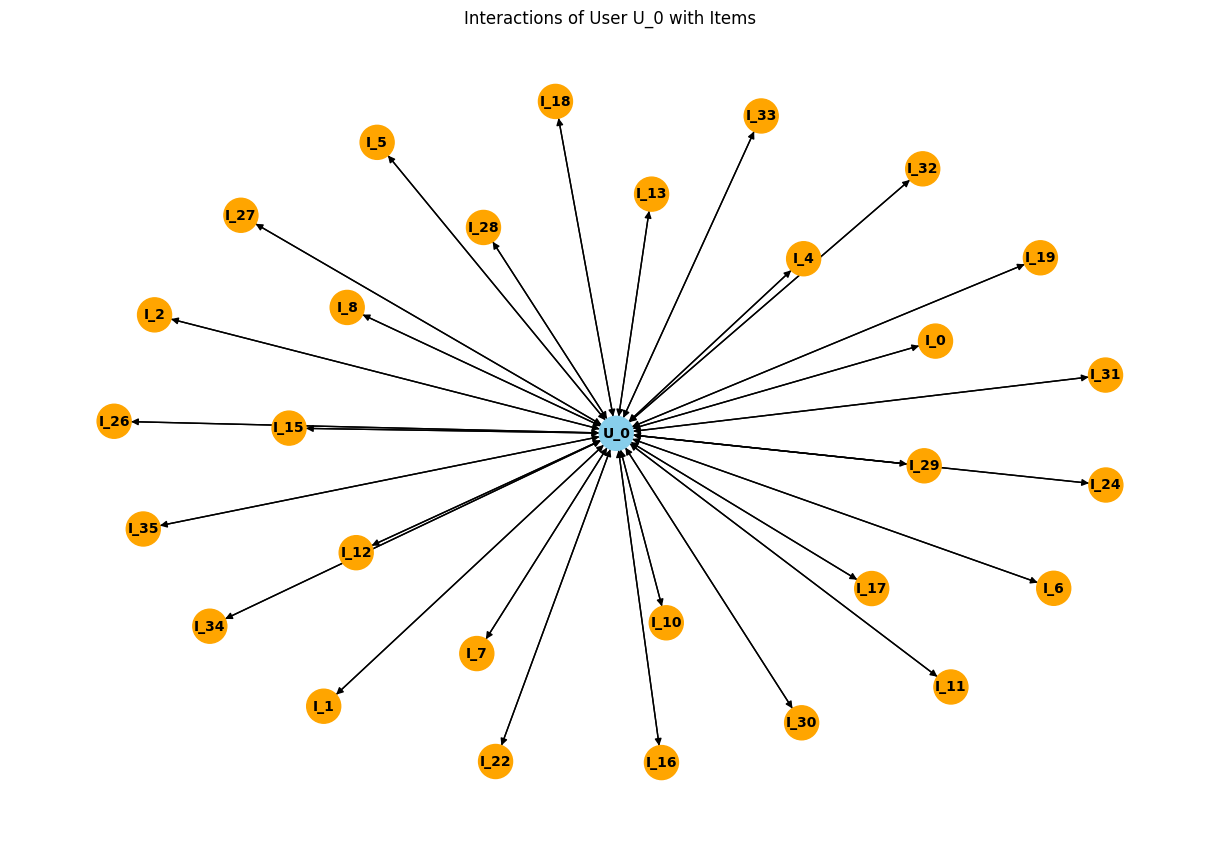

Relations of User U_0 with Items:
U_0 -> I_35: 1
U_0 -> I_34: 1
U_0 -> I_33: 1
U_0 -> I_32: 1
U_0 -> I_31: 1
U_0 -> I_30: 1
U_0 -> I_29: 1
U_0 -> I_28: 1
U_0 -> I_27: 1
U_0 -> I_26: 1
U_0 -> I_24: 1
U_0 -> I_22: 1
U_0 -> I_19: 1
U_0 -> I_18: 1
U_0 -> I_17: 1
U_0 -> I_16: 1
U_0 -> I_15: 1
U_0 -> I_13: 1
U_0 -> I_12: 1
U_0 -> I_11: 1
U_0 -> I_10: 1
U_0 -> I_8: 1
U_0 -> I_7: 1
U_0 -> I_6: 1
U_0 -> I_5: 1
U_0 -> I_4: 1
U_0 -> I_2: 1
U_0 -> I_1: 1
U_0 -> I_0: 1
Displaying User-User Connections


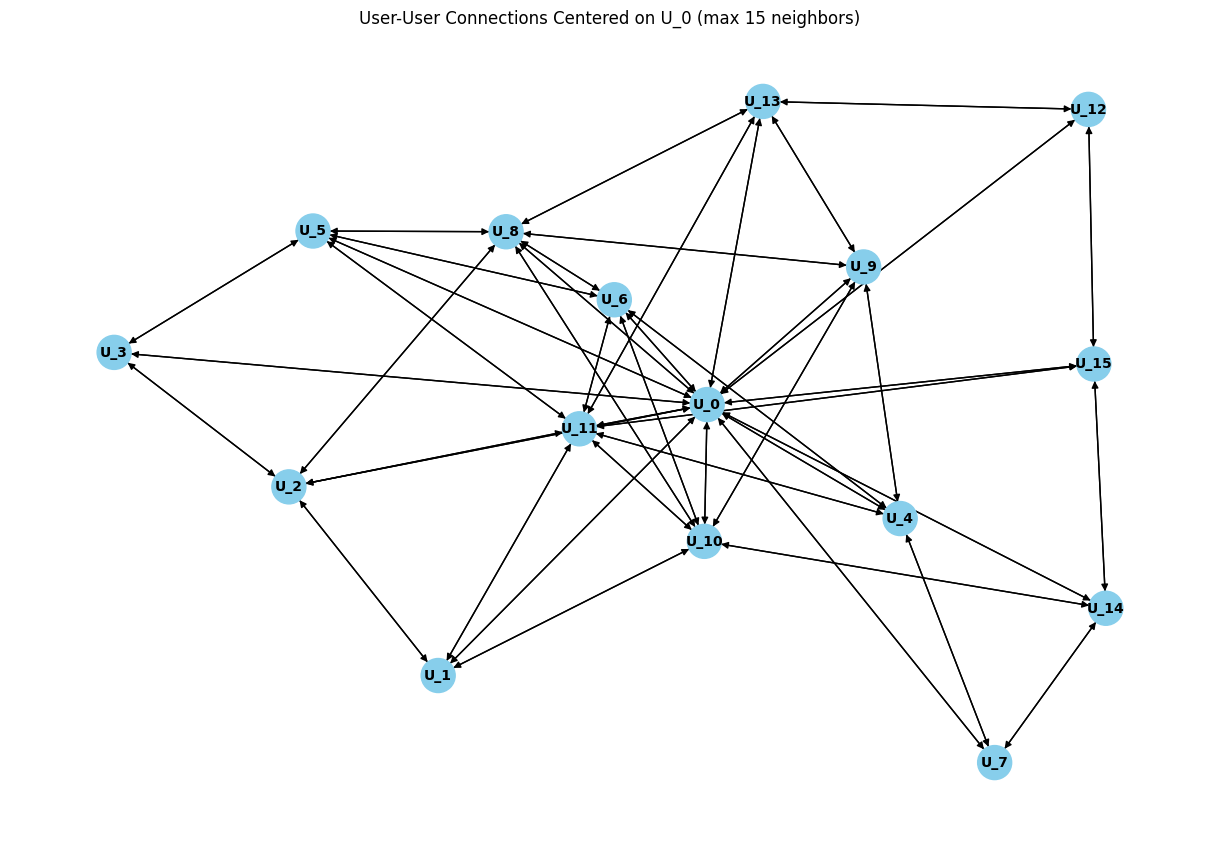

In [81]:
import matplotlib.pyplot as plt
import networkx as nx
import dgl

def visualize_user_item_graph(graph, num_users, num_items, user_id=0):
    """
    Visualize the interactions of a specific user with their items.
    Users are represented in blue and items in orange.
    """
    # Convert the DGL graph to a NetworkX graph for visualization
    nx_graph = graph.to_networkx()

    # Retrieve the neighbors (items) of the user
    neighbors = list(nx_graph.neighbors(user_id))
    
    # Create a subgraph centered on the user
    subgraph = nx_graph.subgraph([user_id] + neighbors)

    # Create labels for nodes: 'U_' prefix for users, 'I_' prefix for items
    labels = {user_id: f"U_{user_id}"}
    for node in neighbors:
        item_index = node - num_users
        labels[node] = f"I_{item_index}"

    # Node colors: blue for user, orange for items
    colors = ['skyblue' if node == user_id else 'orange' for node in subgraph.nodes]

    # Radial layout for highlighting connections
    pos = nx.spring_layout(subgraph, seed=42, center=(0.5, 0.5), scale=1.0)

    # Plotting
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, pos, labels=labels, node_size=600, node_color=colors, font_size=10, font_weight='bold')
    plt.title(f"Interactions of User U_{user_id} with Items")
    plt.show()


def visualize_user_user_graph(graph, num_users, user_id=0, max_neighbors=15):
    """
    Visualize the User-User connections centered around a specific user.
    All nodes (users) are represented in blue.
    - max_neighbors: Limits the number of neighbors to display.
    """
    # Convert the DGL graph to a NetworkX graph for visualization
    nx_graph = graph.to_networkx()

    # Retrieve the neighbors (other users) of the user
    neighbors = list(nx_graph.neighbors(user_id))
    
    # Limit the number of neighbors to display
    if max_neighbors and len(neighbors) > max_neighbors:
        neighbors = neighbors[:max_neighbors]
    
    # Create a subgraph centered on the user
    subgraph = nx_graph.subgraph([user_id] + neighbors)

    # Create labels for nodes with 'U_' prefix for users
    labels = {node: f"U_{node}" for node in subgraph.nodes}

    # Node colors: blue for all nodes
    colors = ['skyblue' for _ in subgraph.nodes]

    # Radial layout for highlighting connections
    pos = nx.spring_layout(subgraph, seed=42, center=(0.5, 0.5), scale=1.0)

    # Plotting
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, pos, labels=labels, node_size=600, node_color=colors, font_size=10, font_weight='bold')
    plt.title(f"User-User Connections Centered on U_{user_id} (max {max_neighbors} neighbors)")
    plt.show()

def print_user_item_relations(train_matrix, user_id):
    """
    Display the User-Item relationships (1 or 0) for a specific user.
    """
    # Extract the interactions for the specified user
    user_interactions = train_matrix.getrow(user_id).tocoo()

    # Print the user-item interactions
    print(f"Relations of User U_{user_id} with Items:")
    for item_idx, value in zip(user_interactions.col, user_interactions.data):
        print(f"U_{user_id} -> I_{item_idx}: {int(value)}")


# Check if the graphs are available
if dataset:
    user_id = 0  # Choose the user to visualize
    max_neighbors = 15  # Limit of neighbors to display

    print("Displaying User-Item Interactions")
    visualize_user_item_graph(ui_graph, NUM_USERS, NUM_ITEMS, user_id=user_id)
    
    print_user_item_relations(train_matrix, user_id)

    print("Displaying User-User Connections")
    visualize_user_user_graph(uu_graph, NUM_USERS, user_id=user_id, max_neighbors=max_neighbors)

else:
    print("Graphs are not yet created.")


In [ ]:
# Save Matrices and Graphs (if needed later)

def save_matrix(matrix, path):
    """ Save matrix as .npy file """
    np.save(path, matrix)

def save_graph(graph, path):
    """ Save graph as .bin file """
    dgl.save_graphs(path, [graph])

if dataset:
    # Save matrices
    save_matrix(binary_train_matrix, os.path.join(SAVE_PATH, 'A_ui.npy'))
    save_matrix(trust_matrix.toarray(), os.path.join(SAVE_PATH, 'A_uu.npy'))

    # Save graphs
    save_graph(ui_graph, os.path.join(SAVE_PATH, 'ui_graph.bin'))
    save_graph(uu_graph, os.path.join(SAVE_PATH, 'uu_graph.bin'))

    print("Data successfully saved.")
else:
    print("Dataset not loaded. Cannot save data.")


Data successfully saved.


## Part II

In [82]:
# Construct the user-item matrix from the training matrix
# Each row represents a user, and each column represents an item

def construct_user_item_matrix(train_matrix):
    """
    Construct the user-item matrix from the training matrix.
    """
    # Convert the sparse matrix to a dense format (1/0 matrix)
    user_item_matrix = train_matrix.toarray()

    print(f"User-Item matrix shape: {user_item_matrix.shape}")
    return user_item_matrix

# Construct the matrix
if dataset:
    user_item_matrix = construct_user_item_matrix(train_matrix)
else:
    print("Dataset not loaded. Cannot construct the user-item matrix.")


User-Item matrix shape: (1925, 15053)


In [85]:
# Import PCA from scikit-learn for dimensionality reduction
from sklearn.decomposition import PCA

def apply_pca(user_item_matrix, n_components=50):
    """
    Apply PCA to reduce the dimensionality of the user-item matrix.
    
    Parameters:
    - user_item_matrix (numpy array or sparse matrix): The original user-item interaction matrix.
    - n_components (int): The number of principal components to keep.

    Returns:
    - reduced_matrix (numpy array): The matrix after dimensionality reduction.
    """
    # Initialize the PCA model with the specified number of components
    pca = PCA(n_components=n_components)
    
    # Apply PCA to the user-item matrix and obtain the reduced matrix
    reduced_matrix = pca.fit_transform(user_item_matrix)

    # Display the shape of the matrix after PCA
    print(f"Reduced matrix shape after PCA: {reduced_matrix.shape}")
    
    # Return the matrix with reduced dimensions
    return reduced_matrix

# Check if the dataset is available before applying PCA
if dataset:
    # Apply PCA to the user-item matrix with the specified number of components
    reduced_matrix = apply_pca(user_item_matrix, n_components=50)
else:
    # Display a message if the user-item matrix is not available
    print("User-Item matrix not available for PCA.")


Reduced matrix shape after PCA: (1925, 50)


In [86]:
# Apply KMeans and Spectral Clustering
from sklearn.cluster import KMeans, SpectralClustering

NUM_CLUSTERS = 10  # Number of clusters for KMeans and Spectral Clustering

def apply_clustering(data, num_clusters):
    """
    Apply KMeans and Spectral Clustering to the data.
    """
    # KMeans Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
    spectral_labels = spectral.fit_predict(data)

    print("Clustering completed.")
    return kmeans_labels, spectral_labels

# Apply clustering
if dataset:
    kmeans_labels, spectral_labels = apply_clustering(reduced_matrix, NUM_CLUSTERS)
else:
    print("Reduced matrix not available for clustering.")


Clustering completed.


In [87]:
# Evaluate clustering using Silhouette Score and Davies-Bouldin Score
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clustering(data, labels, method):
    """
    Evaluate clustering using Silhouette Score and Davies-Bouldin Score.
    """
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)

    print(f"{method} - Silhouette Score: {silhouette:.4f}")
    print(f"{method} - Davies-Bouldin Score: {davies_bouldin:.4f}")

# Evaluate KMeans
evaluate_clustering(reduced_matrix, kmeans_labels, "KMeans")

# Evaluate Spectral Clustering
evaluate_clustering(reduced_matrix, spectral_labels, "Spectral Clustering")


KMeans - Silhouette Score: 0.7669
KMeans - Davies-Bouldin Score: 0.6846
Spectral Clustering - Silhouette Score: -0.3434
Spectral Clustering - Davies-Bouldin Score: 2.3981


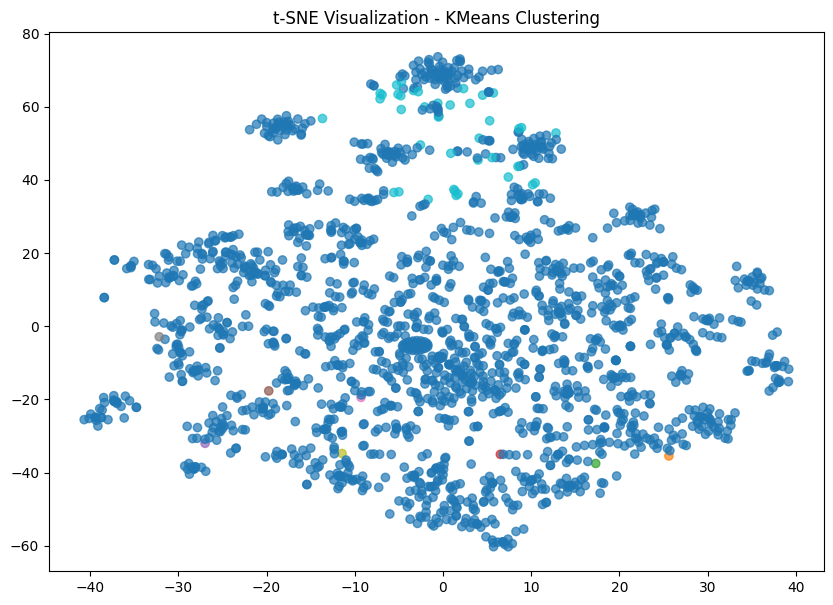

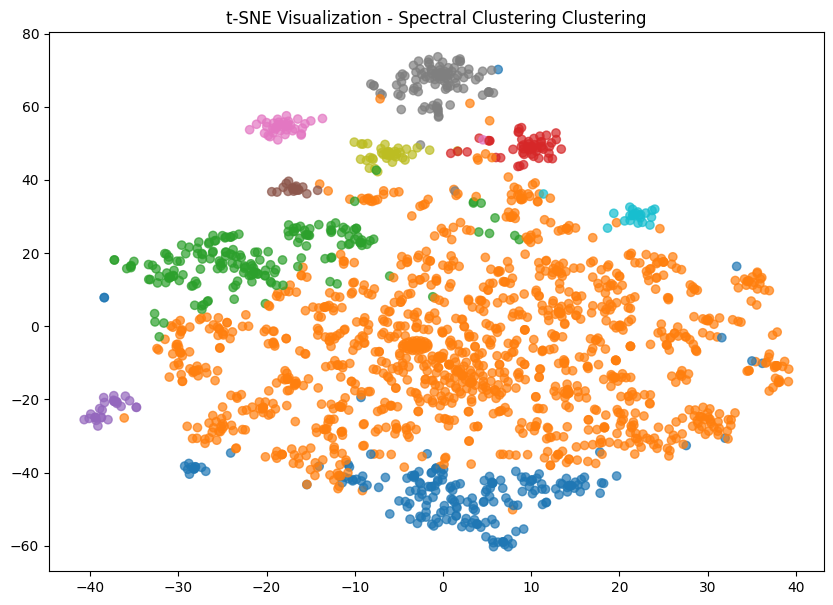

In [88]:
# Visualize clusters using t-SNE
from sklearn.manifold import TSNE

def visualize_clusters(data, labels, method):
    """
    Visualize clusters using t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)

    plt.figure(figsize=(10, 7))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f"t-SNE Visualization - {method} Clustering")
    plt.show()

# Visualize KMeans Clustering
visualize_clusters(reduced_matrix, kmeans_labels, "KMeans")

# Visualize Spectral Clustering
visualize_clusters(reduced_matrix, spectral_labels, "Spectral Clustering")


In [ ]:
# Save cluster labels (if needed for later)

def save_cluster_labels(labels, method):
    """
    Save cluster labels as a dictionary.
    """
    cluster_dict = {f"U_{i}": label for i, label in enumerate(labels)}
    print(f"Cluster labels for {method}:")
    print(cluster_dict)

    return cluster_dict

# Save KMeans labels
kmeans_clusters = save_cluster_labels(kmeans_labels, "KMeans")

# Save Spectral Clustering labels
spectral_clusters = save_cluster_labels(spectral_labels, "Spectral Clustering")


Cluster labels for KMeans:
{'U_0': np.int32(0), 'U_1': np.int32(0), 'U_2': np.int32(0), 'U_3': np.int32(0), 'U_4': np.int32(3), 'U_5': np.int32(0), 'U_6': np.int32(0), 'U_7': np.int32(0), 'U_8': np.int32(0), 'U_9': np.int32(0), 'U_10': np.int32(0), 'U_11': np.int32(2), 'U_12': np.int32(0), 'U_13': np.int32(0), 'U_14': np.int32(0), 'U_15': np.int32(0), 'U_16': np.int32(0), 'U_17': np.int32(0), 'U_18': np.int32(0), 'U_19': np.int32(0), 'U_20': np.int32(0), 'U_21': np.int32(0), 'U_22': np.int32(0), 'U_23': np.int32(0), 'U_24': np.int32(0), 'U_25': np.int32(0), 'U_26': np.int32(0), 'U_27': np.int32(0), 'U_28': np.int32(0), 'U_29': np.int32(0), 'U_30': np.int32(0), 'U_31': np.int32(0), 'U_32': np.int32(0), 'U_33': np.int32(8), 'U_34': np.int32(0), 'U_35': np.int32(0), 'U_36': np.int32(0), 'U_37': np.int32(0), 'U_38': np.int32(0), 'U_39': np.int32(0), 'U_40': np.int32(0), 'U_41': np.int32(0), 'U_42': np.int32(0), 'U_43': np.int32(0), 'U_44': np.int32(0), 'U_45': np.int32(0), 'U_46': np.int32

## Part III

In [89]:
# Parameters for enhanced graph construction
INTRA_CLUSTER_WEIGHT = 1.0   # Weight for intra-cluster connections
INTER_CLUSTER_WEIGHT = 0.2   # Weight for inter-cluster connections

# Choose the clustering method ('kmeans' or 'spectral')
CLUSTERING_METHOD = 'spectral'

# Select the labels based on the chosen clustering method
if CLUSTERING_METHOD == 'kmeans':
    cluster_labels = kmeans_labels
elif CLUSTERING_METHOD == 'spectral':
    cluster_labels = spectral_labels
else:
    raise ValueError("Invalid clustering method selected.")

# Ensure that the clustering labels are available
assert len(cluster_labels) == NUM_USERS, "Cluster labels length mismatch."


In [90]:
import scipy.sparse as sp

def construct_enhanced_uu_graph(num_users, cluster_labels):
    """
    Construct the enhanced User-User graph based on cluster information.
    - Intra-cluster edges have higher weights.
    - Inter-cluster edges have lower weights.
    """
    # Initialize sparse adjacency matrix
    adj_matrix = sp.lil_matrix((num_users, num_users))

    # Iterate over all users to construct connections
    for i in range(num_users):
        for j in range(i + 1, num_users):
            if cluster_labels[i] == cluster_labels[j]:
                # Intra-cluster connection
                adj_matrix[i, j] = INTRA_CLUSTER_WEIGHT
                adj_matrix[j, i] = INTRA_CLUSTER_WEIGHT
            else:
                # Inter-cluster connection
                adj_matrix[i, j] = INTER_CLUSTER_WEIGHT
                adj_matrix[j, i] = INTER_CLUSTER_WEIGHT

    # Convert to CSR format for efficient processing
    adj_matrix = adj_matrix.tocsr()

    print(f"Enhanced User-User graph constructed with shape: {adj_matrix.shape}")
    return adj_matrix

# Construct the enhanced User-User graph
enhanced_uu_graph = construct_enhanced_uu_graph(NUM_USERS, cluster_labels)


Enhanced User-User graph constructed with shape: (1925, 1925)


In [91]:
def update_user_item_graph(train_matrix):
    """
    Update the User-Item graph by maintaining original connections.
    """
    # The User-Item matrix is directly derived from the original training matrix
    updated_ui_graph = train_matrix.tocsr()
    print(f"Updated User-Item graph shape: {updated_ui_graph.shape}")
    return updated_ui_graph

# Update User-Item graph
updated_ui_graph = update_user_item_graph(train_matrix)


Updated User-Item graph shape: (1925, 15053)


In [92]:
def create_feature_matrices(num_users, num_items, cluster_labels):
    """
    Create feature matrices X_ui and X_uu based on cluster labels.
    - X_uu: Each user's cluster is encoded as a feature.
    - X_ui: The User-Item matrix itself is used as a feature matrix.
    """
    # X_uu: Feature matrix for User-User graph (clusters as features)
    X_uu = np.zeros((num_users, NUM_CLUSTERS))
    for i in range(num_users):
        X_uu[i, cluster_labels[i]] = 1

    # X_ui: Feature matrix for User-Item graph (original matrix as features)
    X_ui = train_matrix.toarray()

    print(f"X_uu shape: {X_uu.shape}")
    print(f"X_ui shape: {X_ui.shape}")
    return X_ui, X_uu

# Create feature matrices
X_ui, X_uu = create_feature_matrices(NUM_USERS, NUM_ITEMS, cluster_labels)


X_uu shape: (1925, 10)
X_ui shape: (1925, 15053)


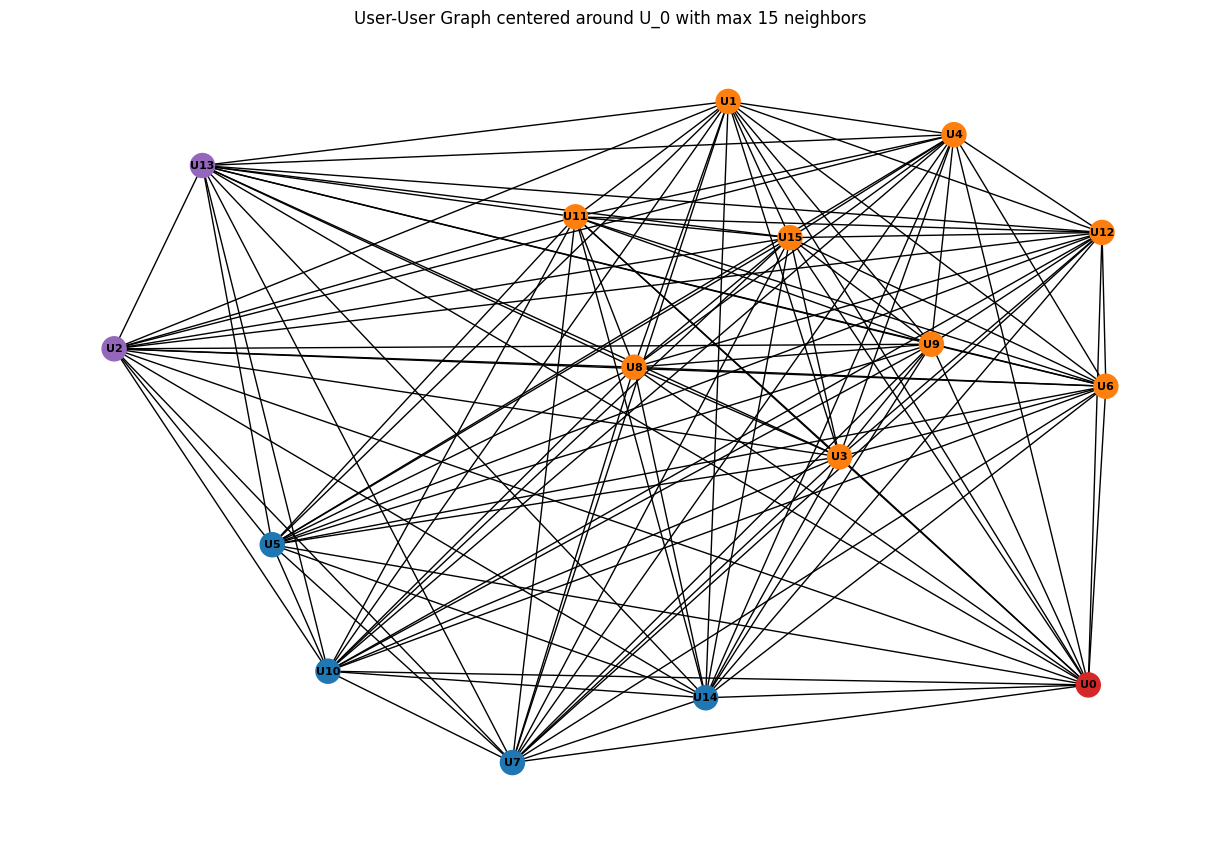

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_partial_uu_graph(adj_matrix, cluster_labels, user_id=0, max_neighbors=10):
    """
    Visualize a subgraph of the enhanced User-User graph centered on a specific user.
    - user_id: The user around which to center the subgraph.
    - max_neighbors: Maximum number of neighbors to display.
    """
    # Convert adjacency matrix to NetworkX graph
    nx_graph = nx.from_scipy_sparse_array(adj_matrix)

    # Get the neighbors of the user
    neighbors = list(nx_graph.neighbors(user_id))
    neighbors = neighbors[:max_neighbors]  # Limit the number of neighbors

    # Create the subgraph centered around the user
    nodes = [user_id] + neighbors
    subgraph = nx_graph.subgraph(nodes)

    # Color mapping based on clusters
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.tab10(unique_labels / unique_labels.max())
    node_colors = [colors[cluster_labels[node]] for node in subgraph.nodes()]

    # Create labels
    labels = {node: f"U{node}" for node in subgraph.nodes()}

    # Plot
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, labels=labels, node_color=node_colors, node_size=300, font_size=8, font_weight='bold')
    plt.title(f"User-User Graph centered around U_{user_id} with max {max_neighbors} neighbors")
    plt.show()

# Subgraph centered around user 0 with a maximum of 15 neighbors
visualize_partial_uu_graph(enhanced_uu_graph, cluster_labels, user_id=0, max_neighbors=15)


## Part IV